### MMA 860 Team Project: Predicting Housing Prices

Team Istanbul

In [24]:
# %pip install openpyxl
# %matplotlib inline
# %pip install statsmodels
# %pip install scikit-learn seaborn
# %pip install jupyter_contrib_nbextensions

In [85]:
import pandas as pd
import numpy as np

import statsmodels.imputation.mice as mice
import statsmodels.api as sm

from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
 
from sklearn import linear_model
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
#Converting data source to dataframes
file_path_test  = "test.csv"
file_path_train = "train.csv"

df_test  = pd.read_csv(file_path_test, index_col="Id")
df_train = pd.read_csv(file_path_train, index_col="Id")

In [27]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### UDFs

In [28]:
#Convert string columns to categorical columns
def to_cat(df):
    cat_cols    = df.select_dtypes(include=['object']).columns.tolist()
    df_dummy    = pd.get_dummies(df, columns=cat_cols, dtype='int')

    return df_dummy 

### Project Code

#### Data Cleaning
1. Check for nulls
2. Check of data-type inconsistencies
3. Check for duplicate rows
4. Check for outliers
5. Test for biases after imputations


In [29]:
#checking for datatype
print(df_train.dtypes)

#Print column with inconsistent datatypes (if any)
for col in df_train.columns:
    unique_types = set(df_train[col].dropna().apply(type)) 
    if len(unique_types) > 1:
        print(f"Column '{col}' has inconsistent data types: {unique_types}")

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object


In [30]:
df_train.shape

(1460, 80)

In [31]:
#check for duplicates
duplicate_count = df_train.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [32]:
cols = df_train.columns.tolist()

#Checking column names; removing spaces from name
for col in cols:
    if ' ' in col:
        new_col = col.replace(' ', '')
        print(f"Removing space in {col}: new name {new_col}")
        
        df_train.rename(columns={col: new_col}, inplace=True)

In [33]:
#Checking if any columns are completely empty
for col in cols:
    if df_train[col].astype(str).str.strip().eq('').all():
        print(f"Column {col} is empty. To be deleted...")

In [34]:
#Checking for nulls in columns (grouped by datatype)

#Initializing lists to store column names with null values
col_num_nulls = []
col_obj_nulls = []

for dtype in sorted(df_train.dtypes.unique(), key=str):  
    
    # Select columns of the current data type and sort by null count
    cols = [col for col in df_train.columns if df_train[col].dtypes == dtype]
    sorted_cols = sorted(cols, key=lambda col: df_train[col].isnull().sum(), reverse=True)
    
    if df_train[col].isnull().sum() == 0:
        print(f"------------- {dtype} -------------")
    
    # Print columns and their respective null counts
    for col in sorted_cols:
        null_count = df_train[col].isnull().sum()
        if null_count > 0:
            print(f"{col} : {null_count}")
            
            #Storing column names in the lists
            if dtype == 'object':
                col_obj_nulls.append(col)
            else:
                col_num_nulls.append(col)

    print("\n")

------------- float64 -------------
LotFrontage : 259
GarageYrBlt : 81
MasVnrArea : 8




------------- object -------------
PoolQC : 1453
MiscFeature : 1406
Alley : 1369
Fence : 1179
FireplaceQu : 690
GarageType : 81
GarageFinish : 81
GarageQual : 81
GarageCond : 81
BsmtExposure : 38
BsmtFinType2 : 38
BsmtQual : 37
BsmtCond : 37
BsmtFinType1 : 37
MasVnrType : 8
Electrical : 1




<h6 style="color: #ff5733;">Null Count Findings:</h6>

1. No spaces found in column names. 
2. There are no columns that are completely empty. 
3. There are no duplicate rows.

**Float Data Type**
1. There are 3 float type columns with null values. 
2. The maximum number of null values in a column are 259. 
3. All null values can be populated using multiple imputations

**Object Data Type**
1. There are 22 object type columns with null values. 
2. There are 4 columns that are more than 45% empty (i.e. less than 55% populated), therefore these columns must be deleted to prevent model skewing:
| Column | Null Values | Percent Empty |
| --- | --- | --- |
| PoolQC | 1453 | 99.5% |
| MiscFeature | 1406 | 96.3% |
| Alley | 1369 | 93.8% |
| Fence | 1179 | 80.7% |
| FireplaceQu | 690 | 47.3% |
3. For the remainder columns, 'None' will replace any empty values in the column. Using 'None' implies that the feature doesn't apply to that record. Adding another value could incorrectly skew the weight & outcome of that column. After adding 'None', <span style="background-color: yellow;"> we need to ensure the value/area of the corresponding feature is 0 (as imputation could add a non-zero value to it.</span> 

In [35]:
#Running multiple imputations on numeric columns feat
df_numeric = df_train.loc[:, col_num_nulls]
imp        = mice.MICEData(df_numeric)
imp.next_sample()

imputed_data = imp.data

# Update df_train with the imputed values
for col in df_numeric.columns:
    df_train[col] = df_train[col].where(df_train[col].notnull(), imputed_data[col])

In [36]:
#Replacing null values in object columns with 'None'
for col in col_obj_nulls:
    df_train[col] = df_train[col].fillna('None')

#Dropping columns that more than 45% empty 
df_train = df_train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1)

In [37]:
#Checking no null values remain
cols = df_train.columns.tolist()

for col in cols:
    null_count = df_train[col].isnull().sum()
    if null_count > 0:
        print(f"{col} : {null_count}")

In [38]:
#Ensuring the value/area of the corresponding feature is 0

#If BsmtQual == None then TotalBsmtSF and TotalBsmtSF should be 0
df_train.loc[df_train['BsmtQual'].isnull(), ['TotalBsmtSF', 'BsmtUnfSF']] = 0

#If BsmtFinType2 == None then BsmtFinSF2 should be 0
df_train.loc[df_train['BsmtFinType2'].isnull(), ['BsmtFinSF2']] = 0

#If BsmtFinType1 == None then BsmtFinSF1 should be 0
df_train.loc[df_train['BsmtFinType1'].isnull(), ['BsmtFinSF1']] = 0

In [39]:
#Checking the above logic is being followed (value/area when feature doesn't exist should be 0)

logic_violated = False

#Check for basement quality vs total basement area & unfinished basement area
if not df_train.loc[df_train['BsmtQual'].isnull() & 
                    ((df_train['TotalBsmtSF'] != 0) | (df_train['BsmtUnfSF'] != 0))].empty:
    print("Rows violating BsmtQual logic:")
    print(df_train.loc[df_train['BsmtQual'].isnull() & 
                       ((df_train['TotalBsmtSF'] != 0) | (df_train['BsmtUnfSF'] != 0))])

#Check for first basement quality and first basement area
if not df_train.loc[df_train['BsmtFinType1'].isnull() & 
                (df_train['BsmtFinSF1'] != 0)].empty:
    print("\nRows violating BsmtFinType1 logic:")
    print(df_train.loc[df_train['BsmtFinType1'].isnull() & 
                       (df_train['BsmtFinSF1'] != 0)])

#Check for second basement quality and second basement are
if not df_train.loc[df_train['BsmtFinType2'].isnull() & 
                    (df_train['BsmtFinSF2'] != 0)].empty:
    print("\nRows violating BsmtFinType2 logic:")
    print(df_train.loc[df_train['BsmtFinType2'].isnull() & 
                       (df_train['BsmtFinSF2'] != 0)])

if not logic_violated:
    print("No logic violdated.")


No logic violdated.


<h5 style="color: blue;">Numeric Columns</h5>

1. Test numeric columns
2. Clean and add data wherever necessary

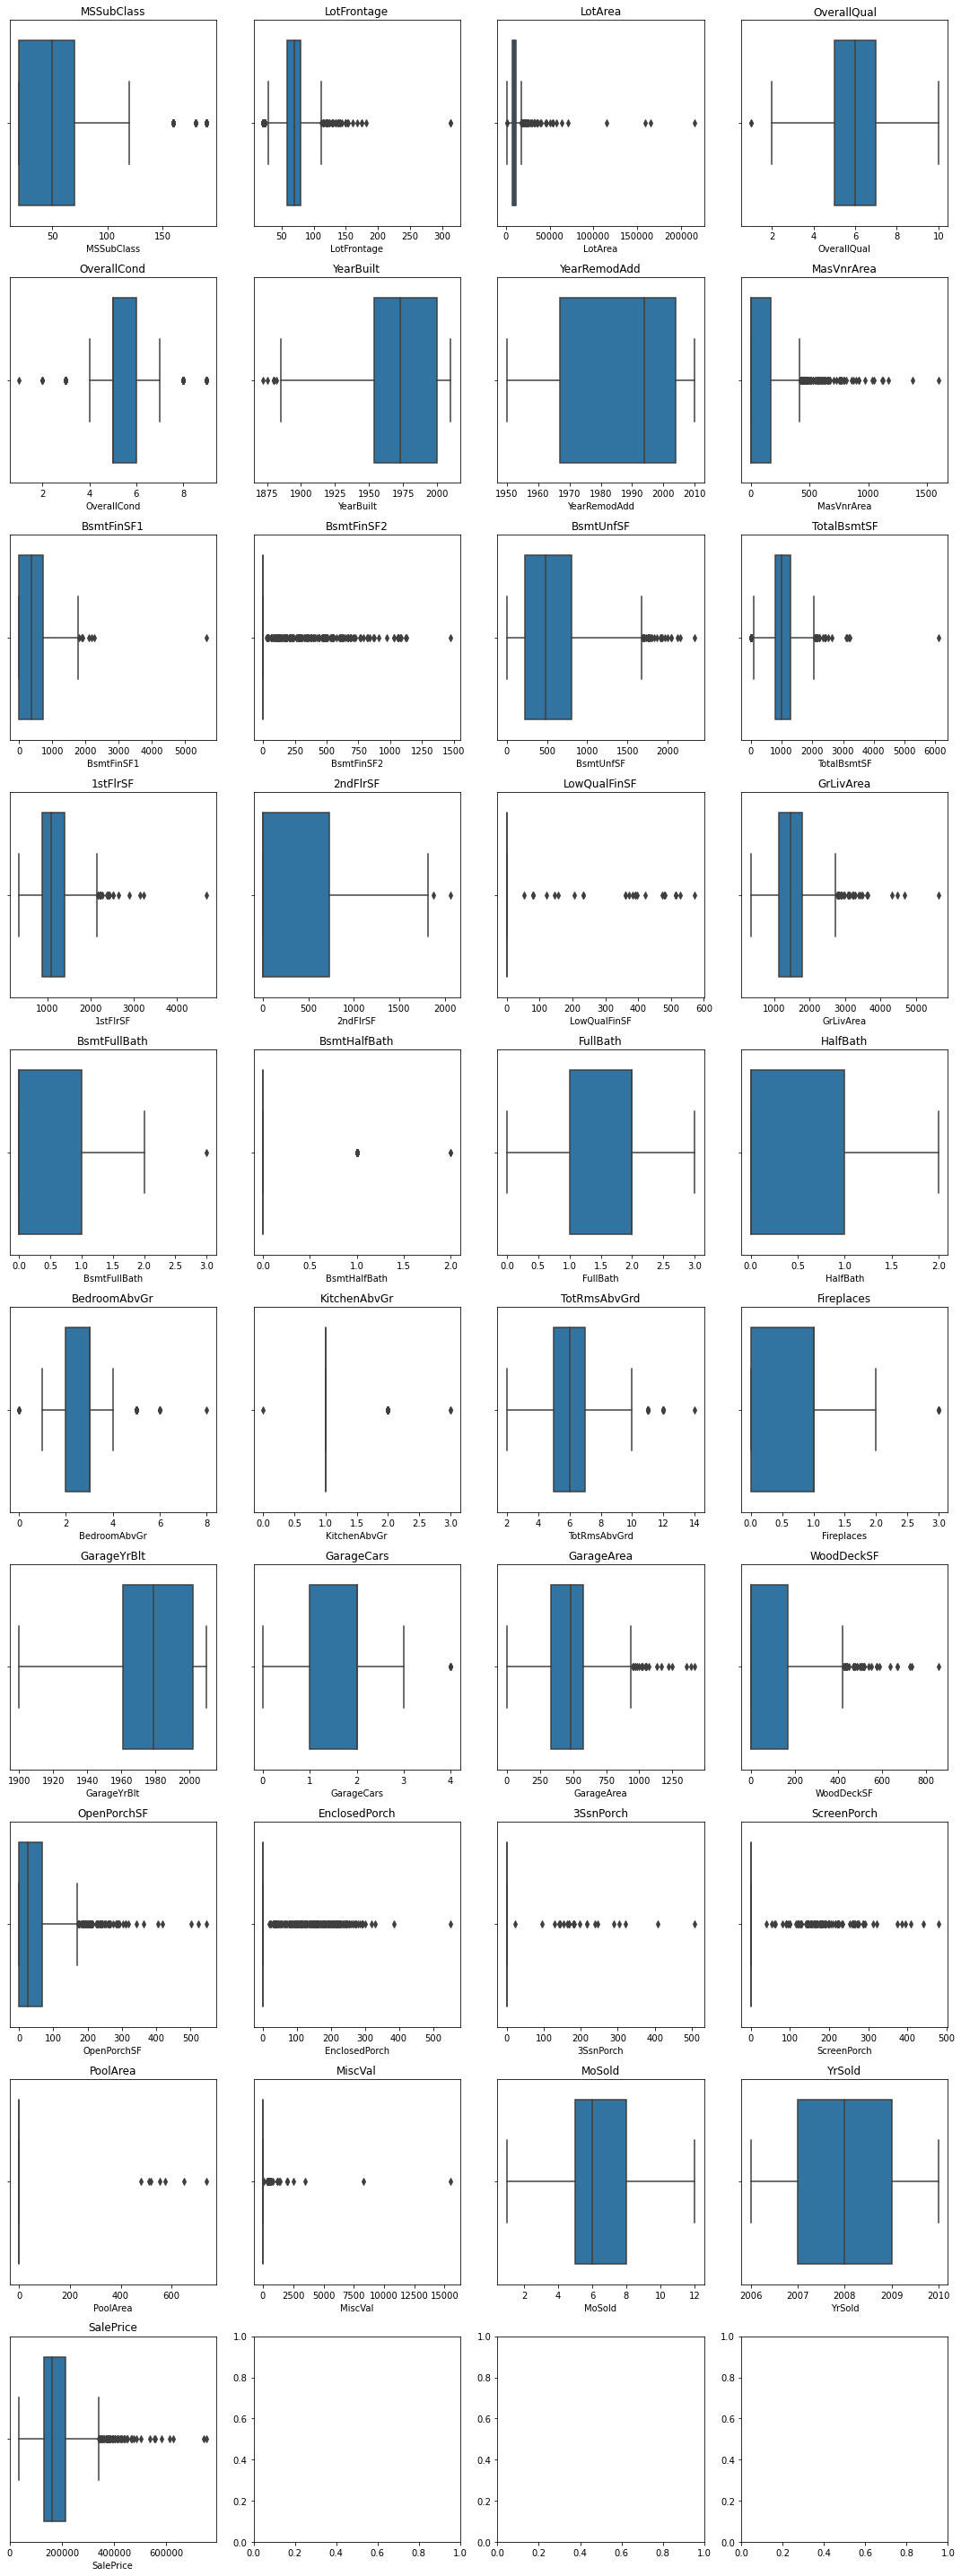

In [40]:
num_cols = df_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Define the number of plots per row
plots_per_row = 4
num_cols_count = len(num_cols)
rows = (num_cols_count // plots_per_row) + (num_cols_count % plots_per_row > 0) 

# Create subplots
fig, axes = plt.subplots(rows, plots_per_row, figsize=(15, rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

# Box plot for each numeric column
for i, col in enumerate(num_cols):
    sns.boxplot(x=df_train[col], ax=axes[i])
    axes[i].set_title(f'{col}')
plt.tight_layout()
plt.show()

<h6 style="color: #ff5733;">Outlier Findings:</h6>

A lot numeric columns contain outliers (as can be seen in the box and whisker plots), however it isn't necessary to remove the outliers because:
1. **Area columns:** For features related to area, the value of 0 is the most frequent value, representing unfinished or non-existent features. In these cases, other values are technically outliers, but 0 simply indicates the absence of that feature. Removing them would misrepresent the data.
2. **Condition columns:** These columns contain ratings for various aspects of the house, such as its condition. While extreme low or high ratings may appear as outliers, they actually reflect the true condition of the house. Removing these values would distort the representation of house conditions.

<h5 style="color: blue;">Categorical Columns</h5>

1. Test categorical columns
2. Clean and add data wherever necessary

In [41]:
#Checking for distinct values in all colums of datatype 'object'
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# 
for col in cat_cols:
    print(f"In column {col}: ")
    print(df_train[col].unique())
    print("\n")

In column MSZoning: 
['RL' 'RM' 'C (all)' 'FV' 'RH']


In column Street: 
['Pave' 'Grvl']


In column LotShape: 
['Reg' 'IR1' 'IR2' 'IR3']


In column LandContour: 
['Lvl' 'Bnk' 'Low' 'HLS']


In column Utilities: 
['AllPub' 'NoSeWa']


In column LotConfig: 
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']


In column LandSlope: 
['Gtl' 'Mod' 'Sev']


In column Neighborhood: 
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']


In column Condition1: 
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']


In column Condition2: 
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']


In column BldgType: 
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']


In column HouseStyle: 
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']


In column RoofStyle: 
['Gable' 'Hip' 

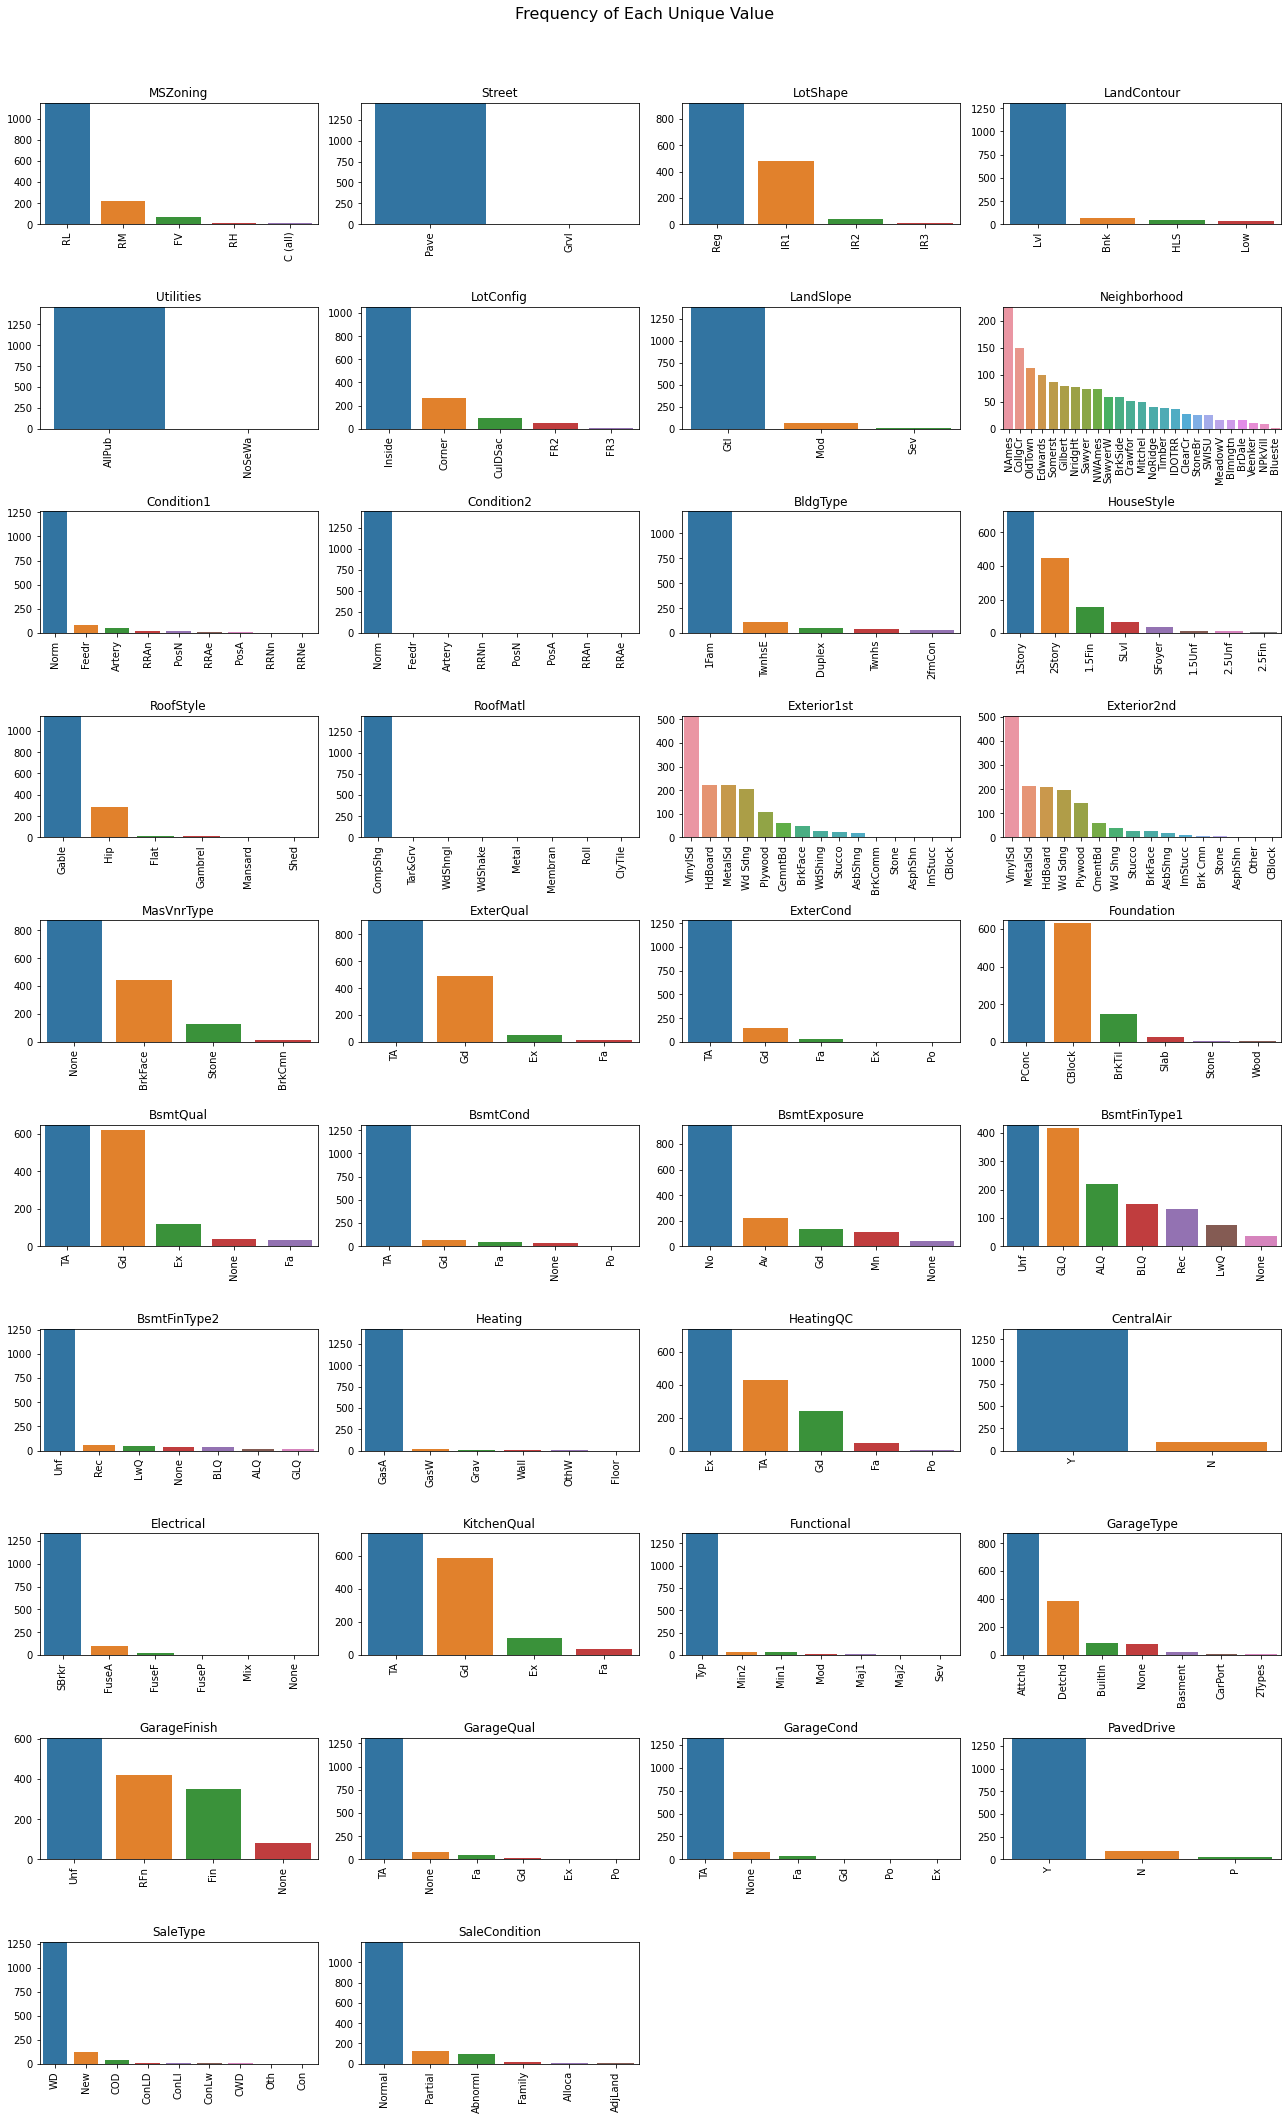

In [42]:
#Plotting the frequency of each unique value
cols = df_train.select_dtypes(include=['object']).columns 
num_cols = len(cols)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)

plt.figure(figsize=(18, num_rows * 3))  
plt.suptitle('Frequency of Each Unique Value', fontsize=16)

index = 1

for index, col in enumerate(cols, start=1):
    plt.subplot(num_rows, 4, index)
    plt.xticks(rotation=90)
    plt.title(col)

    count = df_train[col].value_counts()
    
    sns.barplot(x = count.index, y = count.values)
    
    plt.ylim(0, count.max())
    index +=1
    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [43]:
#From the graphs, testihng counts for columns that appear skewed in value distribution
test_cols = ['Utilities', 'Street', 'Condition2', 'RoofMatl']

for col in test_cols:
    print(f"Column {col} values:")
    print(df_train[col].value_counts())
    print("\n")

Column Utilities values:
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


Column Street values:
Pave    1454
Grvl       6
Name: Street, dtype: int64


Column Condition2 values:
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


Column RoofMatl values:
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64




<h6 style="color: #ff5733;">Unique Value & Frequency Findings:</h6>

Based on the graphs and the 4 columns tested above, one value in each column is over represented. Therefore, in the overall regression model, these columns wouldn't make much of a difference. However, a balance must be maintained between simplifying the model while retaining sensitivity to variance

| Column | Action | Logic |
| :--- | :--- | :--- |
| Utilities | <span style="color: red;">Remove</span> | Column has no variability and will only introduce noise. |
| Street| <span style="color: red;">Remove</span>  | Column has no variability and will only introduce noise. |
| Condition2 | <span style="color: green;">Keep</span> | Even though one value is overrepresented, it's important to keep the variance for model sensitivity |
| RoofMtl | <span style="color: green;">Keep</span> | Even though one value is overrepresented, it's important to keep the variance for model sensitivity |

This approach balances model efficacy and simplicity

#### Exploratory Data Analysis
1. Statistical analysis of variables


#### Feature Engineering
1. Dummy variables/One Hot Encoding
2. Test variable significance
3. Collinearity analysis
4. Dimension reduction

#### Predictive Modelling
1. Multiple Lineaer Regression
2. Heteroskedascity analysis
3. Hypothesis Testing
4. MAE and RMSE analysis

In [44]:
cols = [col for col in df_train.columns if col != 'SalePrice'] 

#Keep the same columns in df_test as df_train
df_test = df_test[cols]

#Add SalePrice column to df_test with empty values
#df_test['SalePrice'] = np.nan 

print(f"df_train: {df_train.shape}")
print(f"df_test: {df_test.shape} (Missing SalePrice)")

df_train: (1460, 75)
df_test: (1459, 74) (Missing SalePrice)


<h5 style="color: blue;">df_test Imputation</h5>

In [46]:
col_obj_test = df_test.select_dtypes(include=['object']).columns.tolist()
col_num_test = df_test.select_dtypes(include=['number']).columns.tolist()

for col in col_obj_test:
    df_train[col] = df_train[col].fillna('None')
    
#Running multiple imputations on numeric columns feat
df_numeric = df_test.loc[:, col_num_test]
imp        = mice.MICEData(df_numeric)
imp.next_sample()

imputed_data = imp.data

# Update df_train with the imputed values
for col in df_numeric.columns:
    df_test[col] = df_test[col].where(df_test[col].notnull(), imputed_data[col])

SyntaxError: invalid syntax (<unknown>, line 1)

In [48]:
# Converting categorical columns to dummy variables
df_train = to_cat(df_train)
features = [col for col in df_train.columns if col != 'SalePrice']

In [49]:
# df_test might have different unique values in object columns, it needs to have the same columns as train
# Extra columns will take value 0 (dummy variable 0 implies the feature is nhot true)
df_test = pd.get_dummies(df_test)
df_test = df_test.reindex(columns=df_train.columns, fill_value = 0)

# if 'SalePrice' in df_test.columns:
#     df_test = df_test.drop('SalePrice', axis=1)

In [50]:
#Ensuring df_test and df_train have the same number of columns
print(f"df_train: {df_train.shape}")
print(f"df_test: {df_test.shape}")

df_train: (1460, 281)
df_test: (1459, 281)


<h5 style="color: blue;">Method: OLS Regression</h5>

In [ ]:
# # Running OLS regression 
# model = ols(f"SalePrice ~" + " + ".join(features), data = df_train)
# model = model.fit

# print(model.summary())

<h5 style="color: blue;">Method: Linear Regression</h5>

In [54]:
#Running Sci-kit regression
y = df_train['SalePrice']
X = df_train[features]

reg = linear_model.LinearRegression()
reg.fit(X, y)

LinearRegression()

In [57]:
#Calcute model statistics
n = X.shape[0]  # number of samples
p = X.shape[1]  # number of features
#y_pred = reg.predict(df_test[features])
y_pred = reg.predict(X)
residuals = y - y_pred

# R-squared
r_squared = reg.score(X, y)

# Adjusted R-squared
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Standard error
std_err = np.sqrt(np.sum(residuals**2) / (n - p - 1))

print(f"""
Regression Summary:
\n
R-squared: {r_squared:.4f}
Adjusted R-squared: {adjusted_r_squared:.4f}
Standard Error: {std_err:.4f}
""")


Regression Summary:


R-squared: 0.9309
Adjusted R-squared: 0.9145
Standard Error: 23231.5991



<h6 style="color: #ff5733;">Model Findings:</h6>
The model has a relatively high R-squared value, therefore implying it is an accurate predictor of house prices

<h5 style="color: blue;">Test: Heteroskedasticity</h5>

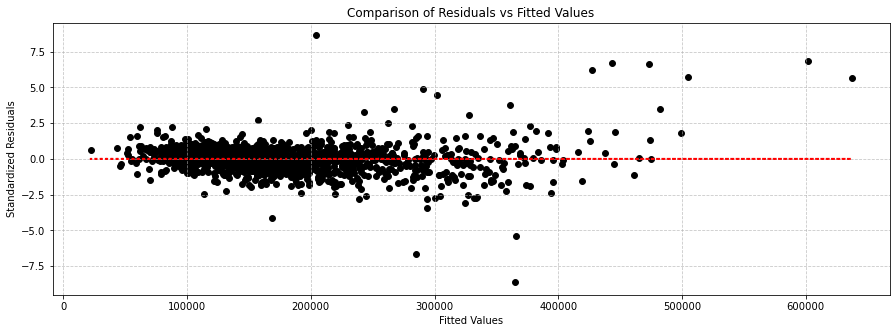

In [60]:
#Plot to check for heteroskedasticity
residuals_array = np.array(residuals).reshape(-1, 1)

scaler          = StandardScaler().fit(residuals_array)
norm_residuals  = scaler.transform(residuals_array)


plt.figure(figsize=(15,5))
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(f"Comparison of Residuals vs Fitted Values")

plt.scatter(y_pred, norm_residuals, c='black', s=35)
plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")


# add trend line  
lin_reg = linear_model.LinearRegression()
lin_reg.fit(reg.predict(X).reshape(-1, 1), norm_residuals)  # Fit to the fitted values
trendline = lin_reg.predict(reg.predict(X).reshape(-1, 1))

# Plot the trendline
plt.plot(y_pred, trendline, color='red', linewidth=2, linestyle='dotted')

In [72]:
# Breusch-Pagan test for heteroskedasticity
bp       = het_breuschpagan(residuals, X)
measures = ('LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value')

for measure, value in zip(measures, bp):
    print(f"{measure}: {value}")

LM Statistic: 861.0360357198088
LM-Test p-value: 1.2387961529141252e-60
F-Statistic: 7.525595381722121
F-Test p-value: 5.712571129206778e-127


<h6 style="color: #ff5733;">Heteroskedasticity Findings:</h6>

1. The model is heteroskedastic as the residuals start off being closer to  the trendline while the house prices are upto $300,000. As the prices increase from there, the residuals also start fanning out. 

2. This implies that the prediction errors grow larger as house prices increase.

| Measure | Value | Conclusion |
| :--- | :--- | :--- |
| LM Statistic | 861.04 | Very high value, cannot be follow X^2 distribution under homoskedasticity |
| LM-Test p-value| 1.239 x 10^(-60)  | Lower than 0.05, confirms heteroskedasticity |
| F-Statistic | 7.53 | F-stat should be close to 0 for it be heteroskedastic distribition |
| F-Test p-value | 5.713 x 10^(-127) | Lower than 0.05, confirms heteroskedasticity |

**Conclusion:** The model can predict lower priced homes more accurately (<$300K) than more luxury homes. 

<h5 style="color: blue;">Test: Normal Q-Q</h5>

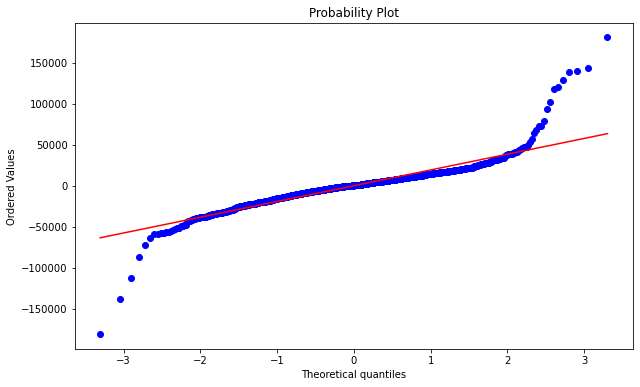

In [93]:
#Creat Q-Q plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

stats.probplot(residuals, dist = 'norm', plot = ax)
plt.show()


ax.set_title("Normal Q-Q Plot of Residuals")
ax.set_xlabel("Theoretical Quantiles")
ax.set_label("Ordered Values")

<h6 style="color: #ff5733;">Normal Q-Q Findings:</h6>

1. The residuals mostly follow the red line closely, especially in the middle of the distribution (around theoretical quantiles -2 to 2). This suggests that the central part of our distribution aligns with a normal distribution.

2. The deviation at the lower tail (below -2) implies that the lower end of the data has smaller values than expected
3. The deviation at the upper tail (above 2) implies upper end of the data has larger than anticipated values

**Conclusion:** The model predictions aren't entirely normally distributed and outliers 

<h5 style="color: blue;">Test: MAE & RMSE</h5>

In [62]:
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"""
MAE: {mae:.2f} 
RMSE: {rmse:.2f}
""")


MAE: 13384.41 
RMSE: 20876.59



In [63]:
mean_price = y.mean() 
mae_percent = (13384.41 / mean_price) * 100
rmse_percent = (20876.59 / mean_price) * 100

print(f"""
MAE is {mae_percent:.1f}% of mean 
RMSE is {rmse_percent:.1f}% of mean
""")



MAE is 7.4% of mean 
RMSE is 11.5% of mean



<h6 style="color: #ff5733;">MAE & RMSE Findings:</h6>

1. The error in the model is **$13,384.41**. The relative error is 7.4% of the mean (since it's less than 10% this is good)

2. The larger errors in the model are close **$20,876.59**. This is 11.5% of the mean (this is a moderate worst case scenario as it's between 10-20%)

**Conclusion:** The model is good for typical cases, however it could require tunining to incorporate extreme scenarios for robustness

In [ ]:
# # Create a StandardScaler instances
# scaler = StandardScaler()

# # Fit the StandardScaler
# X_scaler = scaler.fit(X_train)

# # Scale the data
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# # Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# number_input_features = len(X_train[0])
# hidden_nodes_layer1 = 80
# hidden_nodes_layer2 = 30

# nn = tf.keras.models.Sequential()

# # First hidden layer
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer1, 
#                              input_dim = number_input_features, 
#                              activation = "relu"))

# # Second hidden layer
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, 
#                              activation = "relu"))

# # Output layer
# nn.add(tf.keras.layers.Dense(units = 1, 
#                              activation = "sigmoid"))

# # Check the structure of the model
# nn.summary()

### Appendix

#### Data Dictionary